In [1]:
import logging
import sys
logger = logging.getLogger()
handler = logging.FileHandler('notebook_log.txt')
handler.setLevel(logging.DEBUG)
logger.handlers = [handler]

%matplotlib inline
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np
import imageio
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import networkx as nx

import prep.image_fetcher
import prep.label_converter


IMAGE_PATH = os.path.join("/home/jovyan/benthoz_data", "images")
LABELS_PATH = os.path.join("/home/jovyan/benthoz_data", "labels")

IM_SHAPE = (1024,1360)

if not os.path.exists(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)
    
if not os.path.exists(LABELS_PATH):
    os.mkdir(LABELS_PATH)

IMAGE_LIST_FILE = 'BENTHOZ-2015-imagelist.csv'

# Data Set Preparation
The first step is to:

1. Acquire the images.
2. Check they have been successfully acquired, by comparing them against the training set.

In [2]:
prep.image_fetcher.fetch_all_images(IMAGE_LIST_FILE, IMAGE_PATH)

100% 9874/9874 [00:55<00:00, 178.30it/s] 


In [3]:
# List number of downloaded images
downloaded_images = [f.strip('.tif') for f in os.listdir(os.path.join(IMAGE_PATH)) if f.endswith('tif')]
downloaded_images
len(downloaded_images)

9874

# Defining the Hierarchy and Classes
First, we need to look up the class IDs used in the data set, referencing them against class name as per `id_lookups.csv` (also part of the data set paper).
We then need to build the heirarchy to define parent/child relationships.

In [4]:
df_id_lookups = prep.label_converter.build_hierarchy_from_id_lookup(id_lookup_file='idlookups.csv')
df_id_lookups

,name,parsed_name,depth,child_name,ancestor_id_list,descendant_id_list,bit_vector
id,,,,,,,
1,Not Considered,[Not Considered],1,Not Considered,[],[],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Biota,[Biota],1,Biota,[],"[3, 13, 30, 32, 39, 73, 81, 88, 102, 118, 165,...","[0, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
238,Physical,[Physical],1,Physical,[],"[239, 240, 252, 241, 245, 253, 254, 255, 248, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Worms,"[Biota, Worms]",2,Worms,[2],"[4, 7, 8, 12, 5]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13,Sponges,"[Biota, Sponges]",2,Sponges,[2],"[14, 20, 23, 28, 15, 16, 17, 18, 19, 21, 22, 2...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
161,Cnidaria: Corals: Black & Octocorals: Branchin...,"[Biota, Cnidaria, Corals, Black & Octocorals, ...",7,Arborescent,"[2, 118, 126, 143, 152, 159]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
149,Cnidaria: Corals: Black & Octocorals: Fan (2D)...,"[Biota, Cnidaria, Corals, Black & Octocorals, ...",7,Simple,"[2, 118, 126, 143, 146, 148]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
150,Cnidaria: Corals: Black & Octocorals: Fan (2D)...,"[Biota, Cnidaria, Corals, Black & Octocorals, ...",7,Complex,"[2, 118, 126, 143, 146, 148]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


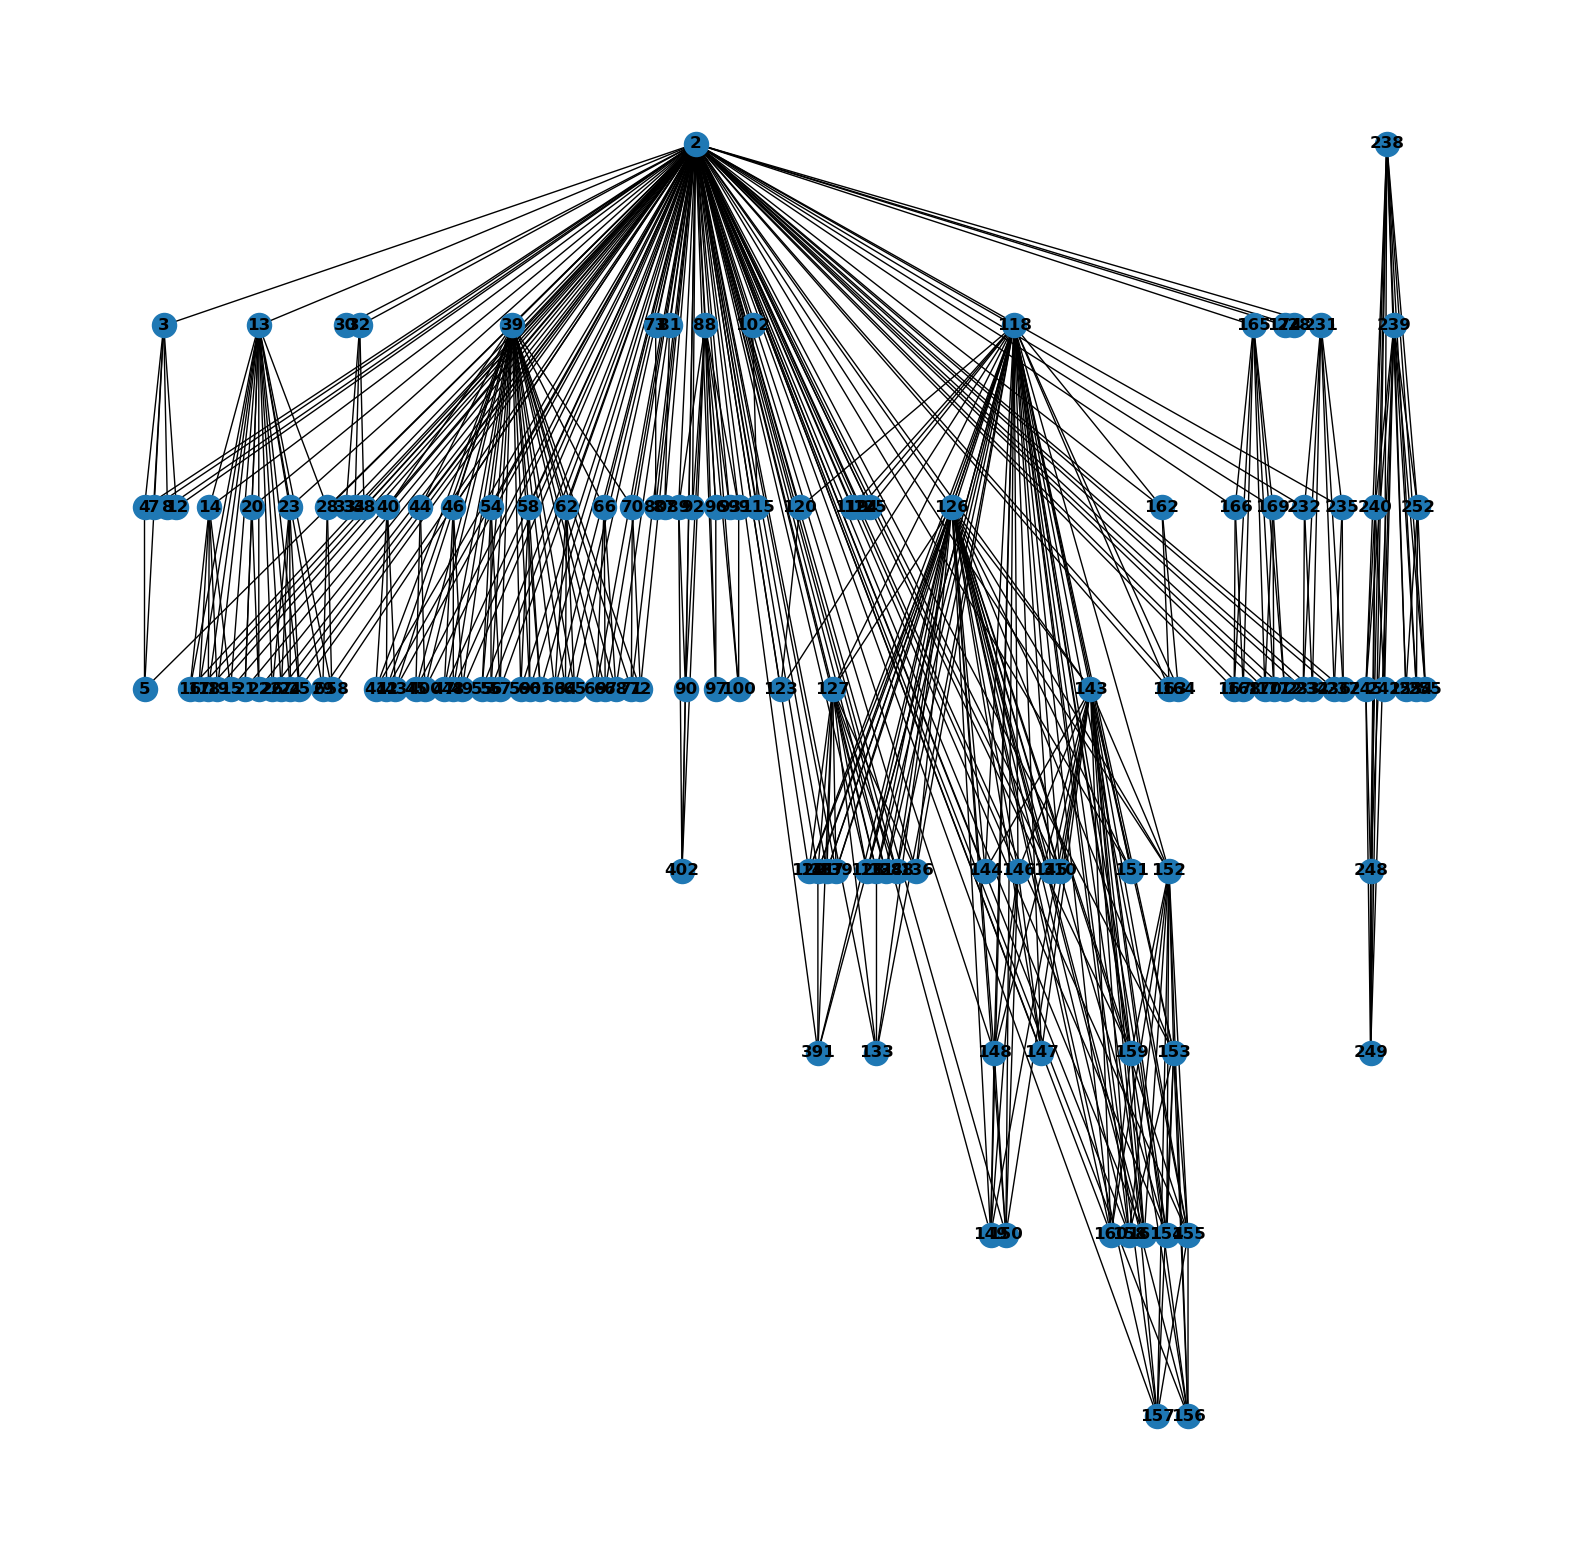

In [6]:
# Visualise  the hierarchy automatically, just to sense check it.  

    
G = nx.Graph()
# G = nx.balanced_tree(5, df_id_lookups.depth.max()-4)

# Driver code
# G.add_nodes_from(df_id_lookups.index)

for row in df_id_lookups.itertuples():
    edges = ([(row.Index, d) for d in row.descendant_id_list])
    if len(edges) > 0:
        G.add_edges_from(edges)
        
# for row in df_id_lookups.itertuples():
#     edges = ([(d, row.Index) for d in row.ancestor_id_list])
#     if len(edges) > 0:
#         G.add_edges_from(edges)

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="dot", args="")
nx.draw(G, with_labels=True, font_weight='bold', ax=plt.gca(), arrows=True, pos=pos)


In [7]:
str(G)

'Graph with 147 nodes and 426 edges'

## Sparse Points to Image Masks
The next step is to convert the sparse lists of points in (image, row, column, label_id) form, to a 1:1 label mask per image. We use the hierarchical relationships between the labels to set it up as a multi-label problem. This means that for an image, the label mask will be a 3D matrix of shape (`len(df_id_lookups)`, `im.shape[0]`, `im.shape[1]`). Each slice in the first index represents a binary mask with 1 as positive, 0 as negative, and -1 as unknown.

In [8]:
DONT_KNOW = -1
NO = 0
YES = 1

def long_labels_to_multilabel_masks(rows, cols, label_ids, im_shape):
    unique_label_ids = list(set(label_ids))
    
    # Stub out the label_mask to -1 for "don't know" unless otherwise specified.
    label_masks = np.ones([len(df_id_lookups), im_shape[0], im_shape[1]], dtype=np.int8) * DONT_KNOW
    for row, col, label_id in zip(*(rows, cols, label_ids)):
        
        # Now we know this particular pixel's value - zero it out, then flip on the relevant bits for the given class to set explicit YES and implicit DONT_KNOWs
        label_masks[:, row, col]
        
        label_masks[:, row, col] = df_id_lookups.loc[label_id, 'bit_vector']
            
    return label_masks

In [9]:
df_training = pd.read_csv('data_splits/public_labels_train.csv')
df_training.head()

,image_name,row,col,label
0,PR_20081006_232302_383_LC16,82,1255,2
1,PR_20081006_232302_383_LC16,114,586,2
2,PR_20081006_232302_383_LC16,119,647,2
3,PR_20081006_232302_383_LC16,120,1011,2
4,PR_20081006_232302_383_LC16,155,50,241


In [10]:
# row and col slightly exceed image dimensions clip.

df_training.loc[:,'row'] = df_training.row.apply(lambda x: int(min(x, IM_SHAPE[0]-1)))
df_training.loc[:,'col'] = df_training.col.apply(lambda x: min(x, IM_SHAPE[1]-1))
df_training.head()

,image_name,row,col,label
0,PR_20081006_232302_383_LC16,82,1255,2
1,PR_20081006_232302_383_LC16,114,586,2
2,PR_20081006_232302_383_LC16,119,647,2
3,PR_20081006_232302_383_LC16,120,1011,2
4,PR_20081006_232302_383_LC16,155,50,241


In [11]:
training_images = df_training.image_name.unique().tolist()

missing_images = list(set(training_images) - set(downloaded_images) & set(training_images))
missing_image_dates = set([s.split('_')[1] for s in missing_images])
print(f'Missing {len(missing_images)} images on dates: {missing_image_dates}')

Missing 0 images on dates: set()


In [12]:
num_images = len(df_training.image_name.unique())
for i, (image_name, g) in tqdm(enumerate(df_training.groupby('image_name')), total=num_images):

    
    # Save labels to disk as npz in similar structure to images
    npz_file = os.path.join(LABELS_PATH, image_name+'.npz')
    if not os.path.exists(npz_file):
        # Prepare the label mask
        labels = long_labels_to_multilabel_masks(g.row, g.col, g.label, IM_SHAPE)
        np.savez_compressed(npz_file, labels=labels)
    else:
        pass
    
    
#     im = cv2.imread(os.path.join(IMAGE_PATH, image_name+'.tif'))
#     visualise_label_layer(45, im, labels)
#     break

    

  0%|          | 0/6853 [00:00<?, ?it/s]

In [13]:
# Convert long-form sparse point labels to "don't know" images. Treat this as multi-class for now (single image, with an indep label assigned to each point)

def visualise_label_layer(label_id, im, labels):
    bitvector_ind = df_id_lookups.reset_index().query("id == @label_id").index.values[0]
    labels_single_layer = labels[bitvector_ind]
    
    # Get positive ones and dilate to make visible.
    labels_single_layer = labels[bitvector_ind,:,:]

    label_name = df_id_lookups.loc[label_id]['name']
    plt.figure(figsize=(20,20))
    plt.imshow(im)
    
    labels_pos = ((labels_single_layer == 1)).astype(np.uint8)
    labels_pos_dilated = cv2.dilate(labels_pos, np.ones((9,9),np.uint8))
    plt.imshow(labels_pos_dilated, alpha=labels_pos_dilated, cmap='brg')
    
    labels_neg = ((labels_single_layer == 0)).astype(np.uint8)
    labels_neg_dilated = cv2.dilate(labels_neg, np.ones((9,9),np.uint8))
    plt.imshow(labels_neg_dilated, alpha=labels_neg_dilated, cmap='seismic')

    plt.title(label_name)


In [ ]:
class_id = 92
description = "Echinoderms: Sea stars"

for i, (image_name, g) in tqdm(enumerate(df_training.groupby('image_name')), total=num_images):
    npz_file = os.path.join(LABELS_PATH, image_name+'.npz')
    labels = np.load(npz_file)["labels"]
    label_counts = (labels>0).sum(axis=1).sum(axis=1)
    df_id_lookups_aug = df_id_lookups.assign(label_counts=label_counts)
    if df_id_lookups_aug.set_index("name").loc[description, "label_counts"] > 2:
        display(df_id_lookups_aug.query("label_counts > 0"))
        im = cv2.imread(os.path.join(IMAGE_PATH, image_name+'.tif'))
        visualise_label_layer(class_id, im, labels)
        break

  0%|          | 0/6853 [00:00<?, ?it/s]